In [10]:
%matplotlib inline
import pandas as pd
import numpy as np 
import os
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import warnings
from functools import reduce
from tools import write_file
import argparse
import multiprocessing
import tools
import importlib
importlib.reload(tools)
from pprint import pprint 

In [3]:
# SET FILE PATHS
path = '/Users/jerryliu/Documents/Vu_uva/internship/CCLE/mutation_files/' # dir contains mutation data 
file_list = ['damaging','hotspot','nonconserving','otherconserving'] # four mutation vectors 
#drug_path = '/Users/jerryliu/Documents/Vu_uva/internship/CCLE/primary-screen-replicate-collapsed-logfold-change.csv'                 
drug_path = "/Users/jerryliu/Documents/Vu_uva/internship/CCLE/Drug_sensitivity_AUC.csv" # drug reponse 
out_path = '/Users/jerryliu/jerry_jupyter/internship/output/' #dir to store predictions
Con_file='/Users/jerryliu/Documents/Vu_uva/internship/CCLE/mutation_files/Census_allSat.csv' # Cosmic gene
                                                                                             # list

In [ ]:
# **Source of the data**:
# Mutation vectors: https://depmap.org/portal/download/    (version: Depmap Public 2021Q4 )
# Drug response data: https://depmap.org/portal/download/   (CUSTOMS DOWNLOADS -> compound 
#                                                               -> Drug sensitivity AUC (CTD^2)
# Cancer gene census: https://cancer.sanger.ac.uk/cosmic/census?genome=37    (in total 729 genes)

In [4]:
#read drug sensitivity files. 
def read_drug(drug_path):
    """ READ DRUG RESPONSE FILE
    return a matrix with cell line ids as row index
    """
    drug_data = pd.read_csv(drug_path)
    drug_data = drug_data.set_index(drug_data.columns[0])
    return(drug_data)

In [5]:
#funtion to merge two mutation files.
def merge_mt(m_f1, m_f2, drug_id, gene_filter = False):
    """ INPUT: [m_f1, m_f2]:  two mutation data matrices 
                    drug_id:  cell line ids in drug response data 
                    gene_filter: * If False:  Merged cell lines =  (m_f1 | drug cl) & (m_f2 | drug cl) 
                                 * If True: merged cell lines = (m_f1 | m_f2) 
                                 * by default (False), the idea is to take union of cell lines from two 
                                   mutation datasets with valid drug reponse targets. For column, we take 
                                   union of genes from two sets. 
        OUTPUT: merged data frame
        FUNCTION: merge two mutation vectors, if a gene has a mutation record (1) in either of the 
                  two vectors, then it is a 1 in the merged data set.
    """
    
    # input: dataframe with index as cell line id. 
    # output: merged dataframe
    #cell lines: m_f1 & m_f2;  cancer genes: m_f1 | m_f2.
    if not gene_filter:
        cl_id = set.union(set.intersection(set(m_f1.index), set(drug_id)), 
                         set.intersection(set(m_f2.index), set(drug_id)))
    else:
        cl_id = set.intersection(set(m_f1.index), set(m_f2.index))
        
    gene_id = set.union(set(m_f1.columns), set(m_f2.columns))

    m_f1 = m_f1.reindex(cl_id, columns = gene_id, fill_value = 0 )
    m_f2 = m_f2.reindex(cl_id, columns = gene_id, fill_value = 0)
    #combine the two files.
    m_comb = pd.DataFrame(np.where(m_f1 == 0, m_f2, m_f1), index = cl_id, columns=gene_id)
    
    return(m_comb)

In [52]:

def EN_cv_in(x_train, y_train, fold, alpha, l1_ratio):
        """
        INPUT: training set. (each alpha, l1_ratio parameter)
        OUTPUT: averge spearman correlation score of 10 results
        FUNCTION: conduct 10 cross validation on the 80 % of resampled dataset
                  to determine the best l1_ratio and alpha pair.
        """
        #alpha = p1, l1_ratio = p2
        kf_in = KFold(n_splits = fold)
        cv_perf = np.array([]) 
        for random_, (train_in, test_in) in enumerate(kf_in.split(x_train)):

            x_train_in, x_test_in, y_train_in, y_test_in = x_train[train_in], x_train[test_in], y_train[train_in], y_train[test_in]

            #build model with each combination of parameters. 
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                regr = ElasticNet(random_state = random_, alpha= alpha, l1_ratio=l1_ratio, 
                                  fit_intercept = False, max_iter= 3000)
                regr.fit(x_train_in, y_train_in)
                
            y_pre = regr.predict(x_test_in)
            #perforamance matrix of the model is the Pearson's corrlation coeeficient r. 
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                r = pd.Series(y_pre).corr(pd.Series(y_test_in), method = 'spearman')
                cv_perf = np.append(cv_perf,[r])
                del regr
        return(np.mean(cv_perf))

    
def out_loop(x, y_total, cl_id, out_cv_fold= 5):
    ''' 5 fold cv (outter-loop)
    # x: (#_(80%)C, #_genes); y: (#_(80%)C,)
    FUNCTION: conduct 5-fold cross validation on the resampled data. In each iteration, conduct
              10 fold CV on the training set (EN_cv_in function) to do parameter search and select the l1
              ratio and alpha with highest validation score on the 10th fold testing set
    '''
    kf = KFold(n_splits = out_cv_fold)
    pre_y_array = dict(list(zip(cl_id,[ [] for _ in range(len(cl_id))])))
    per_test_list = []
    for train, test in kf.split(x):
        x_train, x_test, y_train, y_test = x.values[train], x.values[test], y_total.values[train], y_total.values[test]
        train_label, test_label = x.index[train], x.index[test]
        # 10-fold in x_train (inner-loop). 
        # each pair of alpha and l1_ratio, do cross training to sellect best pair. 

        l1_ratio_list = np.linspace(start = 0.2, stop = 1.0, num = 5) #10 values
        alpha_list =  np.array([math.exp(i) for i in np.arange(-6, 5, 0.8)] ) # 250 values
        #alpha_list =  np.array([math.exp(i) for i in np.arange(-8,5,0.8)]) #  values
        para_matrix = {(l1_ratio, alpha):0 for l1_ratio in l1_ratio_list for alpha in alpha_list}

        for (l1_ratio, alpha) in para_matrix:
            #do ten fold cv to sellect best parameter pairs. 
            ave_per = EN_cv_in(x_train= x_train, y_train = y_train, fold = 8, alpha = alpha, l1_ratio= l1_ratio)
            para_matrix[(l1_ratio, alpha)] = ave_per
        print(para_matrix)
        
        #return the best alpha-l1-ratio pair.
        op_l1_ratio, op_alpha = pd.Series(para_matrix).idxmax() 
        print('the best validation performance is: ', para_matrix[(op_l1_ratio, op_alpha)])
        
        #predict on the 5th-fold set (testing set)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            regr = ElasticNet(random_state=0, alpha= op_alpha, l1_ratio = l1_ratio, 
                              fit_intercept = False, max_iter= 3000)
            regr.fit(x_train, y_train)
            y_pre = regr.predict(x_test)
            
        if len(np.unique(y_pre) ) == 1: print('constant prediction.')
        del regr
        #add results to the storage dictionary. 
        for index, value in zip(test_label, y_pre): pre_y_array[index].append(value)
        per_test = pd.Series(y_pre).corr(pd.Series(y_test),method = 'spearman') 
        per_test_list.append(per_test)
        print('performance on the test set is:', per_test)
        plt.scatter(y_test, y_pre)
        plt.xlabel('test set')
        plt.ylabel('prediction')
        plt.show()
        #break
    #add the prediction to the list.
    pre_y_array = pd.Series(pre_y_array).reindex(cl_id)
    
    return(pre_y_array, per_test_list)


def drug_model(m_file, target, out_path):
    """
    INPUT: m_file mutation matrix with unpreprocessed binery values.
    OUTPUT: mean prediction values of 10 iterations (TYPE: pd.Sereis).
    FUNCTION: conduct normalization + 10 times of 5-fold crossvalidation
    """
    #eliminate cell lines with nan drug sensitivity data.
    drug_name = target.name
    Y = target.dropna()
    m_file_notna = m_file.loc[Y.index,:]

    #normalize the each col to have ~0 mean and ~1 sd. 
    norm_m_file = (m_file_notna - m_file_notna.mean(axis = 0)) / m_file_notna.std(axis = 0)
    
    print('### normalize with mean=0, std = 1.')
    norm_m_file.dropna(axis = 1, inplace = True)
    print('number of features selected {}'.format(norm_m_file.shape[1]))
    X, Y_total = norm_m_file, Y
    
    ### EN model
    ## bootstraping (80% of data) for 10 times. 
    ## each time with 80% data for training and remaining 20% for
    ## testing (5 fold CV).
    cl_id = norm_m_file.index
    Y_pre_array = pd.Series(dict(list(zip(cl_id, [[] for i in range(cl_id.shape[0])]))),
                            index = cl_id, name = drug_name)
    cv_result_list = []
    for i in tqdm(range(10)):
        print('iteration {} begains'.format(i))
        #resample 80% of data
        x, y_total = resample(X, Y_total, replace = False, n_samples = int(X.shape[0]*0.9), random_state = i)
        print(X.isna().sum().sum())
        print(y_total.isna().sum().sum())

        #outter loop with 5 fold cv.
        prediction, cv_list = out_loop(x = x, y_total= y_total, cl_id = cl_id, out_cv_fold=5 )
        cv_result_list.extend(cv_list)
        print('iter {}, outter loop finished. '.format(i))
        
        for i in prediction.index: Y_pre_array[i].extend(prediction[i])

    
    ##calculate the mean of 10 iterations. 
    #Y_pre_array = Y_pre_array.map(np.mean)
    tools.write_file(Y_pre_array, 'comp_{}.csv'.format(drug_name), out_path)
    # list of cross validation results. 
    return(cv_result_list)


In [8]:
#def main():
#STEP 1. ---> load data <---
drug_data = read_drug(drug_path = drug_path)
m_f1, m_f2, m_f3, m_f4  = file_list
m_f1 = pd.read_csv(path + 'CCLE_mutations_bool_' + m_f1 + '.csv', index_col = 0)
m_f2 = pd.read_csv(path + 'CCLE_mutations_bool_' + m_f2 + '.csv', index_col = 0)
m_f3 = pd.read_csv(path + 'CCLE_mutations_bool_' + m_f3 + '.csv', index_col = 0)
m_f4 = pd.read_csv(path + 'CCLE_mutations_bool_' + m_f4 + '.csv', index_col = 0)
print('#### reading files completed')

#### reading files completed


In [11]:
#STEP 2.1 ---> define target cancer genes <---
gene_bankmap = {gene.split(' ')[0]:gene.split(' ')[1] 
 for gene in tools.get_cons(m_f1.columns, m_f2.columns, m_f3.columns, method='union')}

Con_genes = pd.read_csv(Con_file).loc[:,'Gene Symbol'] # Get Cosmis gene list
gene_lists =  [ m_file.columns.map(lambda x:x.split(' ')[0])  # Get union of three gene lists
    for m_file in [m_f1, m_f2, m_f3] ]                        # in mutation files. Here we use first
                                                              # three (m_f1, m_f2, m_f3) mutation vectors.
final_genes = tools.get_cons(tools.get_cons(*gene_lists, method='union'), 
               Con_genes, method = 'inter')  # We take intersection of the Cosmic and CCLE gene list. 
final_genes = [f"{gene} {gene_bankmap[gene]}" for gene in final_genes ]
print(f'number of final genes is {len(final_genes)}')

number of final genes is 710


In [20]:
# STEP 2.2 ---> merge mutation files <---
m_file = merge_mt(merge_mt(m_f1, m_f2, drug_id=drug_data.index), m_f3, 
                  drug_id= drug_data.index,gene_filter=False)      # Merge m_f1, m_f2, m_f3 CCLE
                                                                   # mutation metrices.

print('#### merging mutation files completed')

m_file = m_file.loc[:,final_genes] # Now we take selected 710 genes.
print(m_file.shape)
m_file.head()


#### merging mutation files completed
(812, 710)


,ATP2B3 (492),PML (5371),CNTNAP2 (26047),FLCN (201163),BTK (695),PAFAH1B2 (5049),POU2AF1 (5450),COL2A1 (1280),CYP2C8 (1558),TSC2 (7249),...,CIITA (4261),MACC1 (346389),SETBP1 (26040),DCTN1 (1639),BIRC3 (330),LEPROTL1 (23484),RHOA (387),ATF1 (466),PBX1 (5087),PPM1D (8493)
ACH-000221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACH-000062,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACH-000810,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACH-000447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACH-000571,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# STEP 3. ---> process drug labels <---
# get rid of drugs with too many missing values.
thresh  = int(m_file.shape[0]*(1-0.8)) ## at least 80% of Non-na value in each drug
drug_df = drug_data.loc[m_file.index,:].dropna(axis = 1, thresh = thresh)
print(f'before filtering drugs: the number of drugs is {drug_data.shape[1]}')
print(f'after filtering, the number of drugs is {drug_df.shape[1]}')
print(f'Shape of drug data: {drug_df.shape}')
drug_df.head()

before filtering drugs: the number of drugs is 543
after filtering, the number of drugs is 535
Shape of drug data: (812, 535)


,CIL56 (CTRP:100490),FQI-1 (CTRP:102193),BRD-K92856060 (CTRP:119769),B02 (CTRP:122255),BRD6340 (CTRP:12877),BRD-K45681478 (CTRP:142931),ML050 (CTRP:153820),ML162 (CTRP:154846),CIL41 (CTRP:176181),ML006 (CTRP:17712),...,SZ4TA2 (CTRP:688138),AT13387 (CTRP:688229),BCL-LZH-4 (CTRP:688516),skepinone-L (CTRP:688799),BRD-K34222889 (CTRP:688888),PF-4800567 (CTRP:688962),avicin D (CTRP:688975),linsitinib (CTRP:705300),AT-406 (CTRP:710154),ML031 (CTRP:96171)
ACH-000221,13.460,12.615,13.220,14.778,14.124,11.479,14.447,11.3830,14.408,14.223,...,NaN,NaN,NaN,NaN,10.918,NaN,NaN,13.930,7.5043,14.895
ACH-000062,NaN,NaN,13.643,13.207,14.610,13.946,14.834,10.6260,NaN,14.721,...,14.502,8.4875,14.660,14.322,13.248,14.650,9.5053,13.925,NaN,13.609
ACH-000810,13.924,14.145,13.574,14.887,14.794,12.352,14.318,14.6970,14.731,15.000,...,NaN,NaN,NaN,NaN,12.875,NaN,NaN,15.437,14.7270,14.755
ACH-000447,12.353,13.062,13.115,16.359,14.204,12.116,13.177,9.9236,13.663,12.413,...,NaN,NaN,NaN,NaN,11.624,NaN,NaN,14.316,11.5510,14.874
ACH-000571,NaN,NaN,14.537,13.045,14.696,13.038,13.200,9.3997,NaN,14.926,...,13.589,9.9170,15.512,13.339,14.117,14.717,8.7405,14.678,NaN,13.077


In [47]:
# STEP 4. preprocessing the data 

comp_index = 2  #we build a model for the first drug
target = drug_df.iloc[:,comp_index]
print(f'drug name is {target.name}')

# preprocess
#eliminate cell lines with nan drug sensitivity data.
drug_name = target.name
Y = target.dropna()
m_file_notna = m_file.loc[Y.index,:]

#normalize the each col to have ~0 mean and ~1 sd. 
norm_m_file = (m_file_notna - m_file_notna.mean(axis = 0)) / m_file_notna.std(axis = 0)

norm_m_file.dropna(axis = 1, inplace = True) # Drop genes if it is NAN after normalization 
print('number of features (genes) is: {}'.format(norm_m_file.shape[1]))
norm_m_file.head()
####################
# After normalization many columns are close to 0 and have missing values, 
# so they have to be thrown out. I am wondering if this way of normalization is done rightly?
###################

drug name is BRD-K92856060 (CTRP:119769)
number of features (genes) is: 710


,ATP2B3 (492),PML (5371),CNTNAP2 (26047),FLCN (201163),BTK (695),PAFAH1B2 (5049),POU2AF1 (5450),COL2A1 (1280),CYP2C8 (1558),TSC2 (7249),...,CIITA (4261),MACC1 (346389),SETBP1 (26040),DCTN1 (1639),BIRC3 (330),LEPROTL1 (23484),RHOA (387),ATF1 (466),PBX1 (5087),PPM1D (8493)
ACH-000221,-0.221347,-0.214429,-0.356310,-0.196261,-0.154631,-0.091161,-0.123863,-0.265697,-0.172349,-0.305131,...,-0.244304,-0.172349,-0.285889,-0.203691,-0.149909,-0.064327,-0.188583,-0.118016,-0.159226,-0.200005
ACH-000062,-0.221347,-0.214429,-0.356310,-0.196261,-0.154631,-0.091161,-0.123863,-0.265697,-0.172349,-0.305131,...,-0.244304,-0.172349,-0.285889,-0.203691,-0.149909,-0.064327,-0.188583,-0.118016,-0.159226,-0.200005
ACH-000810,-0.221347,-0.214429,-0.356310,-0.196261,-0.154631,-0.091161,-0.123863,-0.265697,-0.172349,-0.305131,...,-0.244304,-0.172349,-0.285889,-0.203691,-0.149909,-0.064327,-0.188583,-0.118016,-0.159226,-0.200005
ACH-000447,-0.221347,-0.214429,-0.356310,-0.196261,-0.154631,-0.091161,-0.123863,-0.265697,-0.172349,-0.305131,...,-0.244304,-0.172349,-0.285889,-0.203691,-0.149909,-0.064327,-0.188583,-0.118016,-0.159226,-0.200005
ACH-000571,-0.221347,-0.214429,2.802683,-0.196261,-0.154631,-0.091161,-0.123863,-0.265697,-0.172349,-0.305131,...,-0.244304,-0.172349,-0.285889,-0.203691,-0.149909,-0.064327,-0.188583,-0.118016,-0.159226,-0.200005


In [ ]:
## 

In [48]:
# STEP 5. Building the elasticNET model 
# NOTE: HERE only applied 5 fold cv to check if 
# the whole code works. The actual validation schema used 
# is implemented in drug_model FUNCTION (Complete double loop 
# validation cell). 
############################################################
X, Y_total = norm_m_file, Y

# Five fold cross validation 
kf = KFold(n_splits = 5)

per_test_list = []
l1_ratio_list = np.linspace(start = 0.2, stop = 1.0, num = 5) #10 values
alpha_list =  np.array([math.exp(i) for i in np.arange(-6,5,1)] ) # 250 values
#alpha_list =  np.array([math.exp(i) for i in np.arange(-8,5,0.8)]) #  values
para_matrix = {(l1_ratio, alpha):[] for l1_ratio in l1_ratio_list for alpha in alpha_list}

for random_, (train, test) in enumerate(kf.split(X)):
    x_train, x_test, y_train, y_test = X.values[train], X.values[test], Y_total.values[train], Y_total.values[test]

    for randn_, (l1_ratio, alpha) in enumerate(para_matrix):
        #do ten fold cv to sellect best parameter pairs. 
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            regr = ElasticNet(random_state = random_, alpha= alpha, l1_ratio=l1_ratio, 
                              fit_intercept = True, max_iter= 3000)
            regr.fit(x_train, y_train)
            pre = regr.predict(x_test)
            r = pd.Series(pre).corr(pd.Series(y_test), method = 'spearman')
            para_matrix[(l1_ratio, alpha)].append(r)
            
#             plt.scatter(y_test, pre)
#             plt.xlabel('test set')
#             plt.ylabel('prediction')
#             plt.show()
    print('a cv just done')

a cv just done
a cv just done
a cv just done
a cv just done
a cv just done


In [49]:
#show best performance of each parameter search 
best=0
for pra, pre_list in para_matrix.items():
    pre_list = np.array(pre_list)
    if np.isnan(pre_list).sum() != len(pre_list):
        MAX =  np.max(pre_list[~np.isnan(pre_list)]) 
        best = MAX if best <= MAX else best
print(best)

0.2139176476876936


## [Complete double loop validation]

  0%|          | 0/10 [00:00<?, ?it/s]

### normalize with mean=0, std = 1.
number of features selected 707
iteration 0 begains
0
0
{(0.2, 0.0024787521766663585): -0.007766857531375611, (0.2, 0.0055165644207607716): -0.004211594155979053, (0.2, 0.012277339903068436): -0.01008339770402233, (0.2, 0.027323722447292545): -0.012207540195152588, (0.2, 0.060810062625217924): -0.014877601786013307, (0.2, 0.13533528323661256): -0.02018596422859701, (0.2, 0.30119421191220175): -0.02904921718284372, (0.2, 0.6703200460356384): -0.036867667142769074, (0.2, 1.4918246976412681): -0.04088933901812945, (0.2, 3.3201169227365424): -0.10177785765536664, (0.2, 7.389056098930637): -0.019751864236894866, (0.2, 16.444646771097002): nan, (0.2, 36.59823444367791): nan, (0.2, 81.450868664968): nan, (0.4, 0.0024787521766663585): -0.02893609188259745, (0.4, 0.0055165644207607716): -0.01751335473555696, (0.4, 0.012277339903068436): -0.023240593321320148, (0.4, 0.027323722447292545): -0.022307672748133195, (0.4, 0.060810062625217924): -0.03738161835684316

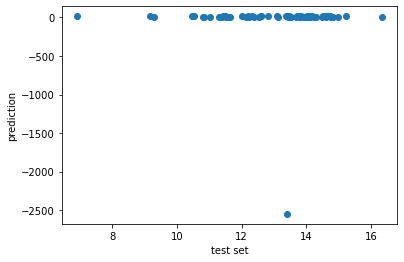

{(0.2, 0.0024787521766663585): -0.012352905260707444, (0.2, 0.0055165644207607716): -0.012985960541268625, (0.2, 0.012277339903068436): -0.01827883619266887, (0.2, 0.027323722447292545): -0.018878111055579398, (0.2, 0.060810062625217924): -0.01767574983390303, (0.2, 0.13533528323661256): -0.01801861615334937, (0.2, 0.30119421191220175): -0.02616212301126312, (0.2, 0.6703200460356384): -0.03313252550311605, (0.2, 1.4918246976412681): -0.04842090400369303, (0.2, 3.3201169227365424): -0.04942677033820787, (0.2, 7.389056098930637): nan, (0.2, 16.444646771097002): nan, (0.2, 36.59823444367791): nan, (0.2, 81.450868664968): nan, (0.4, 0.0024787521766663585): -0.00932570754492624, (0.4, 0.0055165644207607716): -0.020953848585193606, (0.4, 0.012277339903068436): -0.014307979946325607, (0.4, 0.027323722447292545): -0.015947920051979137, (0.4, 0.060810062625217924): -0.014171302087523579, (0.4, 0.13533528323661256): -0.01658586140093918, (0.4, 0.30119421191220175): -0.012792607396412976, (0.4, 0

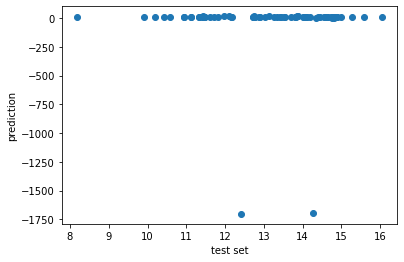

{(0.2, 0.0024787521766663585): 0.01643142590774747, (0.2, 0.0055165644207607716): 0.009756996943323194, (0.2, 0.012277339903068436): 0.014901509083267372, (0.2, 0.027323722447292545): 0.00850961242700378, (0.2, 0.060810062625217924): 0.003174049057870488, (0.2, 0.13533528323661256): 0.00577778751387879, (0.2, 0.30119421191220175): 0.010300564930198639, (0.2, 0.6703200460356384): 0.01665564388309158, (0.2, 1.4918246976412681): 0.011293946391979698, (0.2, 3.3201169227365424): 0.032544996899239745, (0.2, 7.389056098930637): nan, (0.2, 16.444646771097002): nan, (0.2, 36.59823444367791): nan, (0.2, 81.450868664968): nan, (0.4, 0.0024787521766663585): 0.0022038058616956416, (0.4, 0.0055165644207607716): 0.00766175656950498, (0.4, 0.012277339903068436): 0.0016620737108197607, (0.4, 0.027323722447292545): -0.002768127339377008, (0.4, 0.060810062625217924): -0.001405921510711866, (0.4, 0.13533528323661256): 0.002419279664818863, (0.4, 0.30119421191220175): 0.01403174489272644, (0.4, 0.670320046

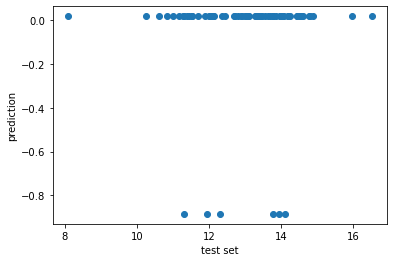

{(0.2, 0.0024787521766663585): 0.06200250139790606, (0.2, 0.0055165644207607716): 0.06630230371799369, (0.2, 0.012277339903068436): 0.07246370068095456, (0.2, 0.027323722447292545): 0.07036561981052138, (0.2, 0.060810062625217924): 0.07564846957068241, (0.2, 0.13533528323661256): 0.07857876155818858, (0.2, 0.30119421191220175): 0.07963845579749612, (0.2, 0.6703200460356384): 0.09016611544998758, (0.2, 1.4918246976412681): 0.08151886193308937, (0.2, 3.3201169227365424): 0.00011928168033358867, (0.2, 7.389056098930637): nan, (0.2, 16.444646771097002): nan, (0.2, 36.59823444367791): nan, (0.2, 81.450868664968): nan, (0.4, 0.0024787521766663585): 0.054104810128644445, (0.4, 0.0055165644207607716): 0.052860771028513415, (0.4, 0.012277339903068436): 0.06362566263598804, (0.4, 0.027323722447292545): 0.06082981650358938, (0.4, 0.060810062625217924): 0.05746066391304388, (0.4, 0.13533528323661256): 0.060160834249600025, (0.4, 0.30119421191220175): 0.06275120139813686, (0.4, 0.6703200460356384):

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


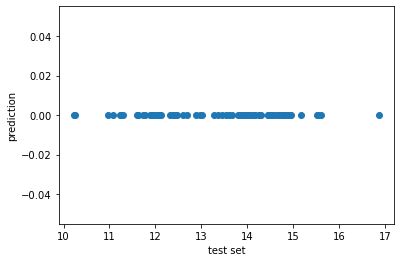

{(0.2, 0.0024787521766663585): -0.05361291742870692, (0.2, 0.0055165644207607716): -0.04842088328930435, (0.2, 0.012277339903068436): -0.0487621079726343, (0.2, 0.027323722447292545): -0.04104687394161079, (0.2, 0.060810062625217924): -0.04041353383458647, (0.2, 0.13533528323661256): -0.04191813994445574, (0.2, 0.30119421191220175): -0.05016680214048636, (0.2, 0.6703200460356384): -0.054665379665379675, (0.2, 1.4918246976412681): -0.04376905100589312, (0.2, 3.3201169227365424): -0.06199430991639378, (0.2, 7.389056098930637): nan, (0.2, 16.444646771097002): nan, (0.2, 36.59823444367791): nan, (0.2, 81.450868664968): nan, (0.4, 0.0024787521766663585): -0.05032005689900427, (0.4, 0.0055165644207607716): -0.050320056899004276, (0.4, 0.012277339903068436): -0.051629072681704274, (0.4, 0.027323722447292545): -0.0473751947436158, (0.4, 0.060810062625217924): -0.04287577050734947, (0.4, 0.13533528323661256): -0.04011887827677301, (0.4, 0.30119421191220175): -0.043921459053038, (0.4, 0.67032004

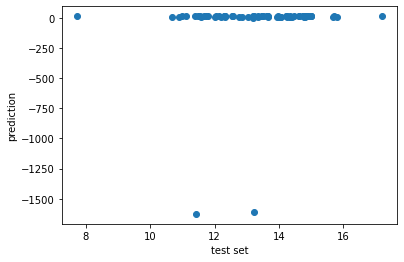

 10%|█         | 1/10 [09:56<1:29:32, 596.92s/it]

iter 0, outter loop finished. 
iteration 1 begains
0
0


 10%|█         | 1/10 [11:34<1:44:11, 694.66s/it]


KeyboardInterrupt: 

In [53]:

#build model for each drug.
"""Training schema: 1. Bootstrapping 80% of the data (FUNCTION "drug_model")
                    2. Outter loop to split resampled data into 5-folds for training and 
                         validation (implemented in FUNCTION "out_loop" )
                    3. During each iteration of training, apply inner 10-fold loop cross 
                       validation to select best l1 ratio and alpha pair. (FUNCTION EN_cv_in)
                    4. Vaildate on the 5th fold testing set. 
""" 

comp_index = 0
target = drug_df.iloc[:,comp_index]
pre = drug_model(m_file, target, out_path=out_path) 




    

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument("-t", "--target_index", type=int,
                        help= "target index (1-based)")
    parser.add_argument("-o","--output", type = str,
                        help= "output file's dir ")
    args = parser.parse_args()
    
    dg_index = args.target_index
    out_dir = args.output
    
    main()